In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

In [2]:
filepath_home= 'D:/Dacon_Psychological_disposition/'
filepath_out = 'C:/임시/Dacon_Psychological_disposition/' 
train = pd.read_csv(filepath_home+'train_na_filled.csv')
test = pd.read_csv(filepath_home+'test_na_filled.csv')

In [3]:
# 분할 지점 저장해두고 데이터 통합 후 전처리
split_point = train.shape[0]
data = pd.concat([train.drop('voted',axis=1),test],ignore_index=True)

In [4]:
# 마키아 스코어 계산
total_negative_cols = ["QeA", "QfA", "QkA", "QqA", "QrA", "QaA", "QdA", "QgA", "QiA", "QnA"]
data[total_negative_cols] = 6-data[total_negative_cols]
data['mach_score'] = data.apply(lambda x:x.iloc[0:40:2].mean(),axis=1)

In [5]:
# tipi 성격 구분 5 칼럼 추가
data[['tp02','tp04','tp06','tp08','tp10']]= 7-data[['tp02','tp04','tp06','tp08','tp10']]

data['Extraversion']=(data.tp01+data.tp06)/2
data['Agreeableness']=(data.tp02+data.tp07)/2
data['Conscientiousness']=(data.tp03+data.tp08)/2
data['Emotional Stability']=(data.tp04+data.tp09)/2
data['Openness to Experiences']=(data.tp05+data.tp10)/2

In [10]:
# 각 답변 시간을 빠르다/느리다 로 이분화 후 전체 설문의 답변시간을 0~20 사이로 수치화
#total_median = np.median(np.ravel(train.iloc[:,1:40:2]))
total_median = data.iloc[:,1:40:2].median()
temp_df = np.where(data.iloc[:,1:40:2]>total_median,1,0)
data['Q_total_E'] = temp_df.sum(axis=1) # 0~20

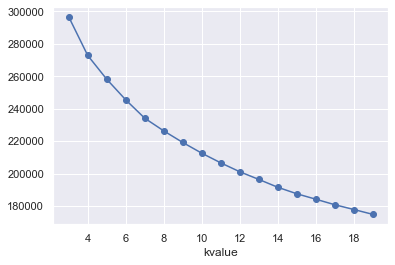

In [33]:
from sklearn.preprocessing import MinMaxScaler,StandardScaler
from sklearn.cluster import KMeans

data['age'] = data['age_group'].map({'10s':1,'20s':2,'30s':3,'40s':4,'50s':5,'60s':6,'+70s':7})
data['sex'] = data['gender'].map({'Male':1,'Female':0})

subcols = ['Q_total_E','mach_score','Extraversion','Agreeableness','education','married','sex','age']
subdata = (data.iloc[:split_point][subcols]).join(train.voted)
ss = StandardScaler()
subdata= ss.fit_transform(subdata)

dist =[]
k_list = list(range(3,20))
for i in k_list:
    km = KMeans(n_clusters=i,init = 'k-means++',n_init=10,max_iter = 200)
    km.fit(subdata)
    dist.append(km.inertia_)
plt.plot(k_list,dist,marker = 'o')
plt.xlabel('kvalue')
plt.show()

In [34]:
knn = KMeans(n_clusters =5,init = 'k-means++')
knn.fit(subdata)
pd.DataFrame(ss.inverse_transform(knn.cluster_centers_),columns=subcols+['voted'])

,Q_total_E,mach_score,Extraversion,Agreeableness,education,married,sex,age,voted
0,10.952776,3.583662,3.815982,3.505659,3.003220,1.257976,1.000000,2.477022,1.228022
1,10.640375,2.975193,3.584214,2.582907,1.928533,1.042924,0.327160,1.457130,1.991176
2,6.757320,4.084881,4.312858,4.528811,1.949568,1.060227,0.777951,1.421590,1.917787
3,9.108752,3.210542,3.681094,2.987206,3.069008,1.210426,0.000272,2.392813,1.174493
4,12.341269,2.818308,3.419788,2.279568,3.007098,2.374031,0.381566,4.303920,1.368243
